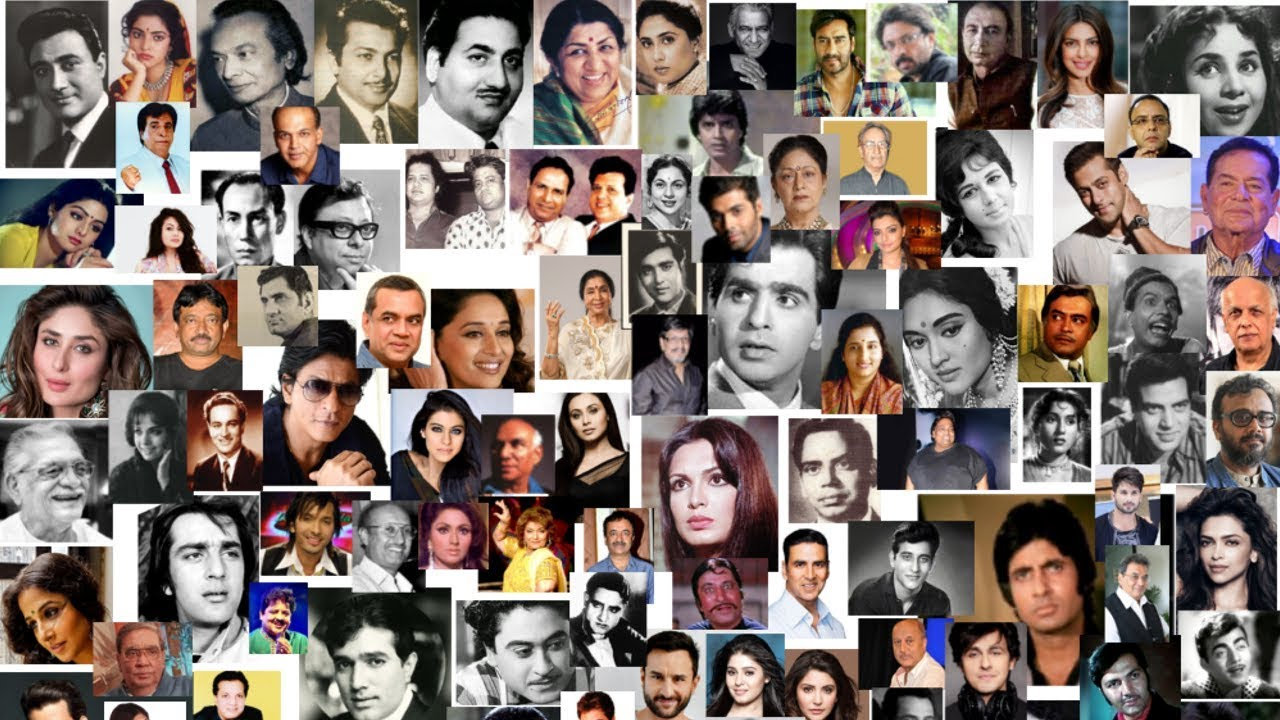

# MOVIES REVIEW RATING PREDICTION

# Importing necessary libraries

In [598]:
import numpy as np
import pandas as pd

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#preprocessing
from sklearn.preprocessing import MinMaxScaler

#model selection and evaluation
from sklearn.model_selection import train_test_split, cross_val_score

#handle warnings
import warnings
warnings.filterwarnings('ignore')

# Reading the Data

In [599]:
imdbData = pd.read_csv('/content/IMDb_Movies_India.csv', encoding= 'latin-1')
imdbData.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


# Overview of the Data

In [600]:
def DataOverview(imdbData, msg):
  print(f'{msg}\n')
  print(f'Data has {imdbData.shape} rows and columns respectively\n')
  print(f'COLUMNS LIST: {imdbData.columns}\n')
  print(f'DATA TYPE OF EACH COLUMN:\n{imdbData.dtypes}\n')
  print(f'DESCRIPTIVE DATA OF THE RATING(NUMERIC) COLUMN:\n{imdbData.describe()}\n')
  print(f'NULL VALUES COUNT:\n{imdbData.isnull().sum()}')

DataOverview(imdbData, 'Movies Data Overview...')

Movies Data Overview...

Data has (15509, 10) rows and columns respectively

COLUMNS LIST: Index(['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director',
       'Actor 1', 'Actor 2', 'Actor 3'],
      dtype='object')

DATA TYPE OF EACH COLUMN:
Name         object
Year         object
Duration     object
Genre        object
Rating      float64
Votes        object
Director     object
Actor 1      object
Actor 2      object
Actor 3      object
dtype: object

DESCRIPTIVE DATA OF THE RATING(NUMERIC) COLUMN:
            Rating
count  7919.000000
mean      5.841621
std       1.381777
min       1.100000
25%       4.900000
50%       6.000000
75%       6.800000
max      10.000000

NULL VALUES COUNT:
Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64


# INFERENCES
* The dataset has 15509 rows and 10 columns.
* Only 'Rating' column has numeric values.
* There are way too many null values and such a data needs to be handled rightly.

# DATA CLEANING

Null Values Analysis

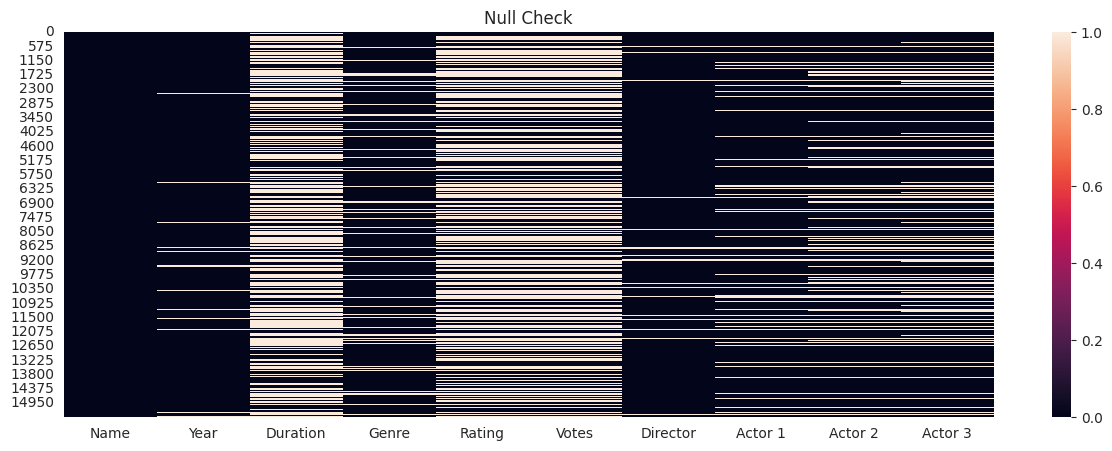

In [601]:
plt.figure(figsize=(15,5), dpi=100)
sns.heatmap(imdbData.isnull())
plt.title('Null Check')
plt.show()

'Duration', 'Rating' and 'Votes' have most null entries.
So, let's know the exact count...

In [602]:
#Sorting null values count
imdbData.isnull().sum().sort_values(ascending=False)

Duration    8269
Rating      7590
Votes       7589
Actor 3     3144
Actor 2     2384
Genre       1877
Actor 1     1617
Year         528
Director     525
Name           0
dtype: int64

Let's drop 'Actor 1' and 'Actor 2' columns as they have too many null values and are not very important for our prediction

In [603]:
imdbData.drop(['Actor 2','Actor 3'], axis=1, inplace=True)

In [604]:
imdbData.columns

Index(['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director',
       'Actor 1'],
      dtype='object')

Now, let's drop the records containing null values in the 'Duration' column

In [605]:
imdbData.dropna(subset=['Duration'],inplace=True)

In [606]:
imdbData.isnull().sum()

Name           0
Year         125
Duration       0
Genre        187
Rating      1389
Votes       1389
Director      14
Actor 1      264
dtype: int64

Let's also drop the records containing the null values in the 'Rating' and 'Votes' column

In [607]:
imdbData.dropna(subset=['Rating','Votes'],inplace=True)

In [608]:
imdbData.isnull().sum()

Name         0
Year         0
Duration     0
Genre       31
Rating       0
Votes        0
Director     1
Actor 1     75
dtype: int64

Now, we have only 1 null value in the 'Director' column. So, instead of, dropping the record, I can simply replace the missing value with the most repeated value.

In [609]:
imdbData.Director.describe()

count             5850
unique            2549
top       David Dhawan
freq                41
Name: Director, dtype: object

I can replace the missing value with 'David Dhawan'.

In [610]:
imdbData['Director'].fillna('David Dhawan',inplace=True)

'Genre' column has 31 missing values.
Let's look for the frequent value in the Genre column and its count

In [611]:
imdbData.Genre.describe()

count      5820
unique      393
top       Drama
freq        870
Name: Genre, dtype: object

From the above observation, I'd like to replace the missing values with Drama

In [612]:
imdbData['Genre'].fillna('Drama',inplace=True)

We have 75 missing values in the 'Actor 1' column.
Let's again check for the frequent value in this column...

In [613]:
imdbData['Actor 1'].describe()

count                 5776
unique                2046
top       Amitabh Bachchan
freq                   104
Name: Actor 1, dtype: object

Replacing the missing values with 'Amitabh Bachchan'.

In [614]:
imdbData['Actor 1'].fillna('Amitabh Bachchan',inplace=True)

In [615]:
imdbData.isnull().sum()

Name        0
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
dtype: int64

Let's convert the 'Year' and 'Duration' column to numeric instead of the object type.

In [616]:

imdbData['Year'] = imdbData['Year'].str.replace(r'[()]','').apply(pd.to_numeric)

imdbData['Duration'] = imdbData['Duration'].str.replace('min','').apply(pd.to_numeric)

imdbData['Votes'] = imdbData['Votes'].str.replace(',', '').astype(int)

In [617]:
#Checking dtype of each column
imdbData.dtypes

Name         object
Year          int64
Duration      int64
Genre        object
Rating      float64
Votes         int64
Director     object
Actor 1      object
dtype: object

Now, we see that the 'Year', 'Duration', 'Rating' and 'Votes' are our numerical columns.

Now, our data is clean and ready for analysis.

# EXPLORATORY DATA ANALYSIS AND DATA VISUALIZATION

# Correlation between the numerical columns

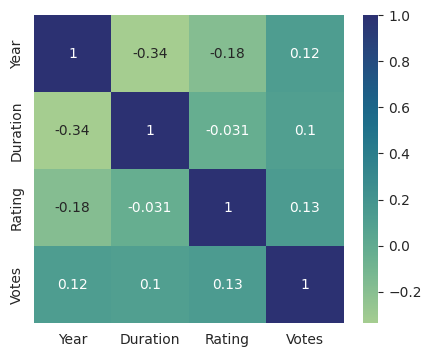

In [618]:
plt.figure(figsize=(5,4))
sns.heatmap(imdbData.corr(), annot=True, cmap='crest')
plt.show()

# Year data distribution

<Axes: ylabel='Year'>

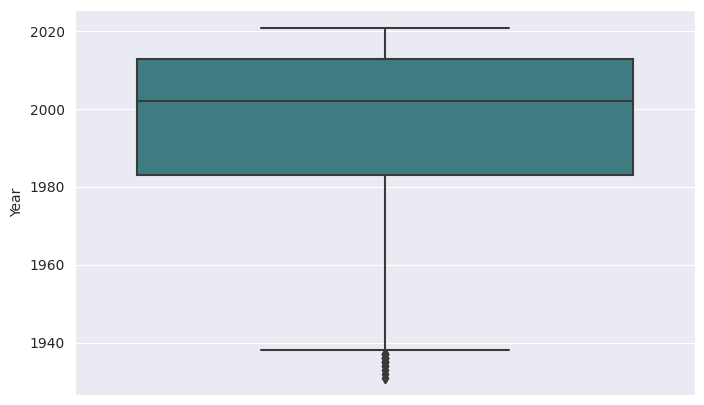

In [619]:
plt.figure(figsize=(8,5))
sns.boxplot(data=imdbData, y='Year', palette='crest')

So, the data basically consists of movies released between 1930 and 2020.

## Movie count each year

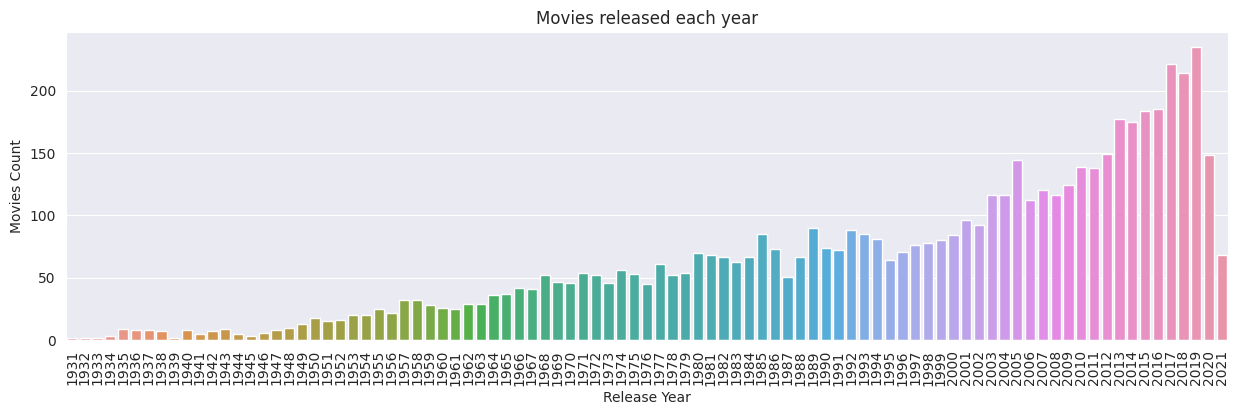

In [620]:
plt.figure(figsize=(15,4))
year_count = imdbData['Year'].value_counts().reset_index()
year_count.columns = ['Year', 'Count']
sns.barplot(x='Year', y='Count', data=year_count)
plt.xticks(rotation=90)
plt.title("Movies released each year")
plt.xlabel('Release Year')
plt.ylabel('Movies Count')
plt.show()

We can see there are most movies in the 2000s.

# Directors with most movies

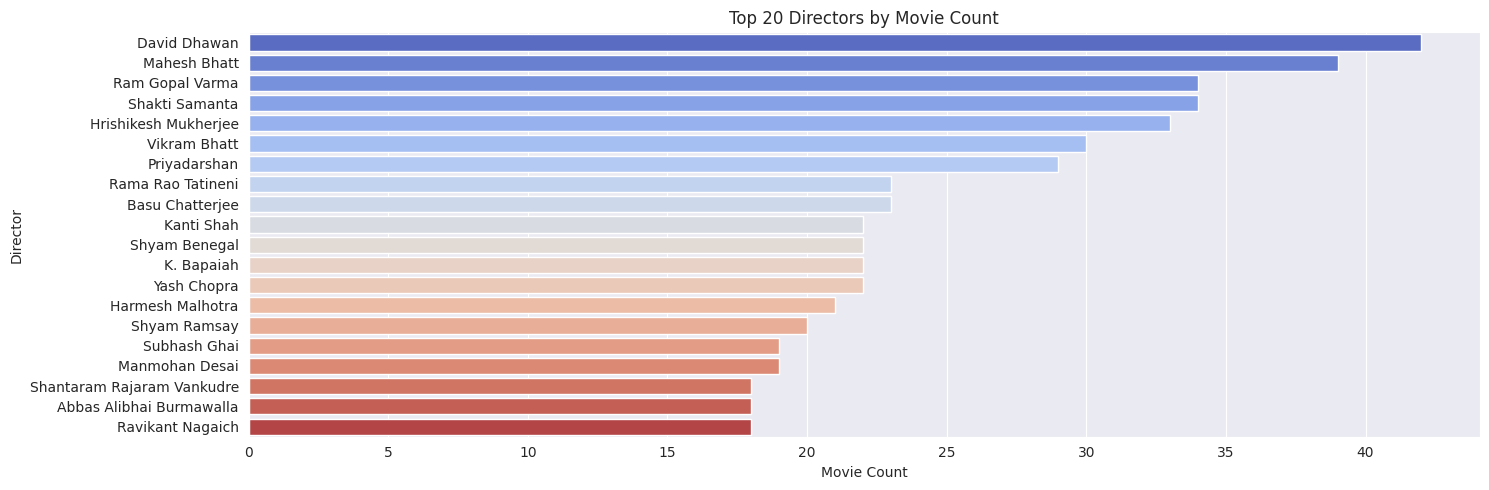

In [621]:
director_movie_count = imdbData['Director'].value_counts().reset_index()
director_movie_count.columns = ['Director', 'Movie Count']

director_movie_count = director_movie_count.sort_values(by='Movie Count', ascending=False)

top_20_directors = director_movie_count.head(20)

plt.figure(figsize=(15, 5))
sns.barplot(data=top_20_directors, x='Movie Count', y='Director', palette='coolwarm')
plt.xlabel('Movie Count')
plt.ylabel('Director')
plt.title('Top 20 Directors by Movie Count')
plt.tight_layout()

plt.show()

David Dhavan and Mahesh Bhatt have most movies

# Actors with most movies

In [622]:
Actor_Info = imdbData['Actor 1'].dropna()
Actor_Info['Count'] = 1

Test = Actor_Info.value_counts().rename_axis('Actor').reset_index(name='Count')

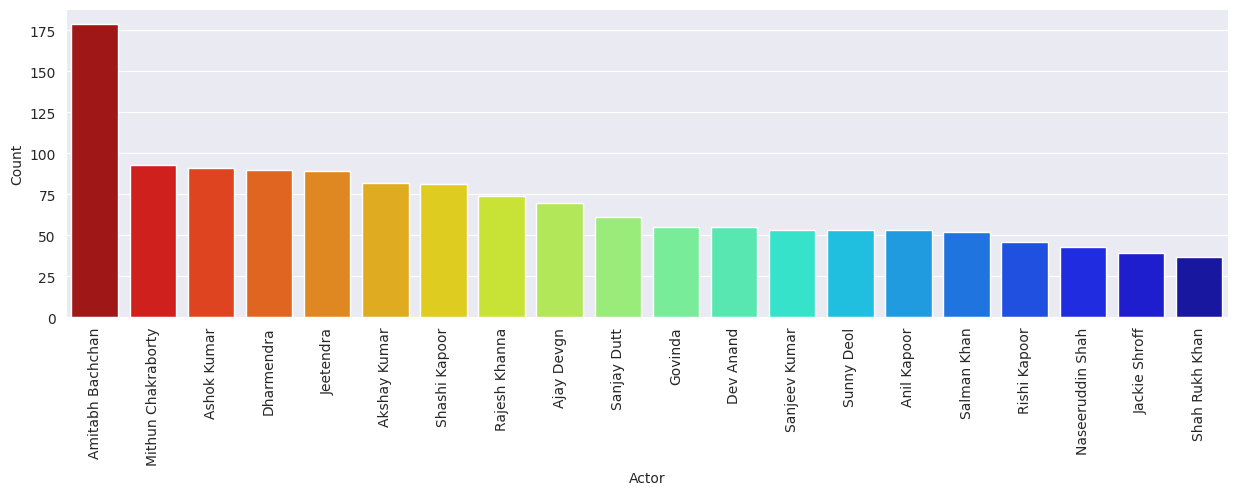

In [623]:
plt.figure(figsize=(15,4))
sns.barplot(x="Actor", y="Count", data=Test[0:20], palette= 'jet_r')
plt.xticks(rotation=90)
plt.show()

As seen earlier, Amitabh Bachchan has most movies.

# RATINGS ANALYSIS

Ratings Distribution

<Axes: ylabel='Density'>

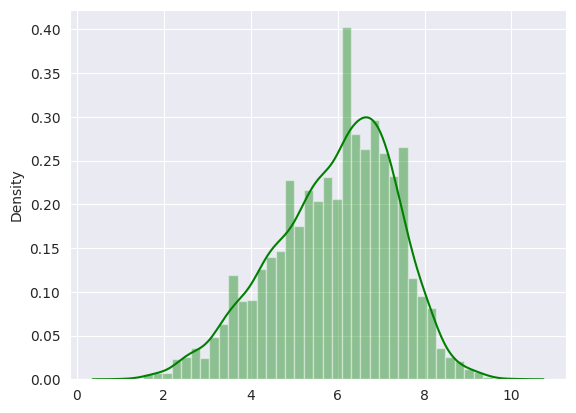

In [624]:
sns.set_style('darkgrid')
sns.distplot(imdbData, x=imdbData['Rating'], color='g')

<Axes: xlabel='Rating', ylabel='Votes'>

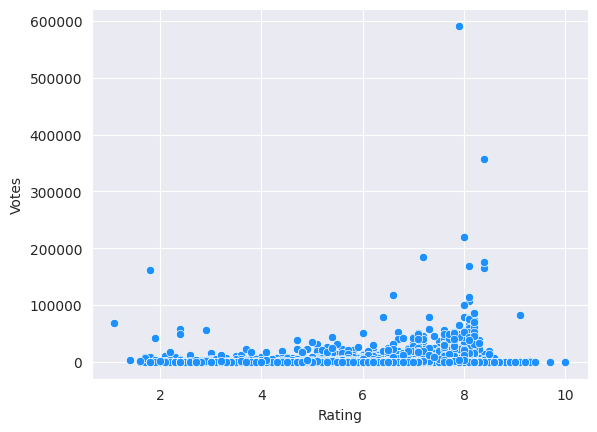

In [625]:
sns.set_style('darkgrid')
sns.scatterplot(x=imdbData['Rating'],y=imdbData['Votes'], color='dodgerblue')

Let's also analyze movies based on their rating...

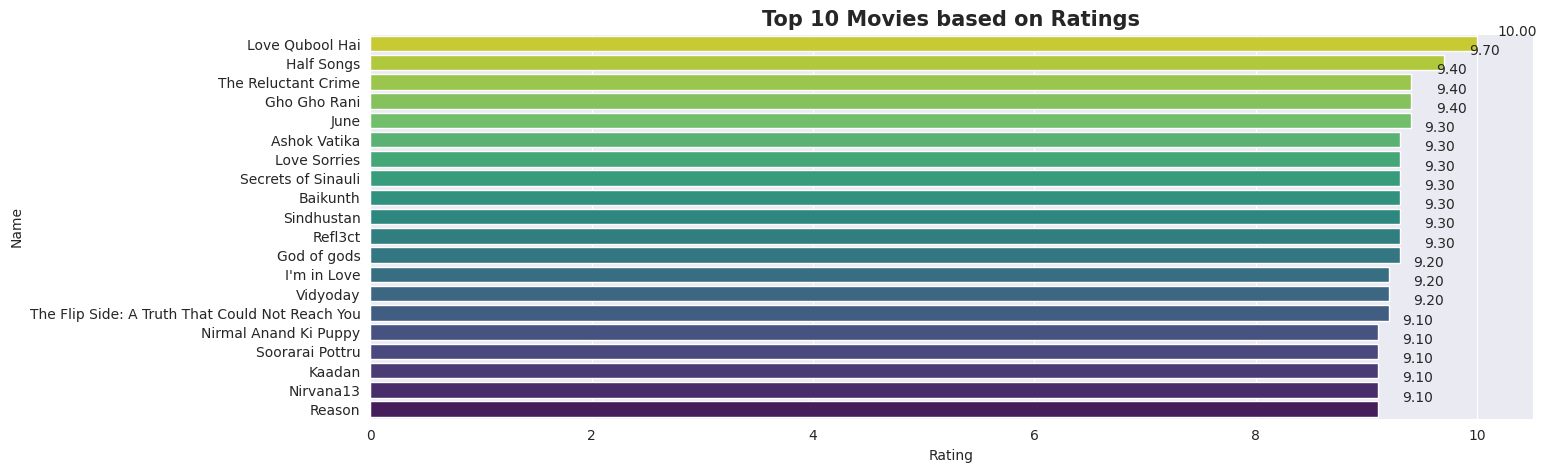

In [626]:
plt.figure(figsize=(15,5))

df = imdbData.set_index('Year')

top_movies = df[['Name','Rating']].sort_values(by = 'Rating', ascending=False).head(20)

moviePlots = sns.barplot(x='Rating', y='Name', data=top_movies, palette='viridis_r')

for bar in moviePlots.patches:
  moviePlots.annotate(format(bar.get_width(),'.2f'),(bar.get_x() + bar.get_width()+0.3, bar.get_y()+0.5), ha='center',va='center',size=10, xytext=(5,10), textcoords='offset points')
  plt.xlabel("Rating",fontsize=10)
plt.ylabel("Name",fontsize=10)
plt.title("Top 10 Movies based on Ratings",fontsize=15,fontweight='bold')
plt.xticks(np.arange(0,11,2))
plt.yticks()
plt.show()

'Love Qubool Hai', 'Half Songs', 'The Reluctant Crime' are highly rated movies...

Similarly, let's also look for the top directors based on rating...

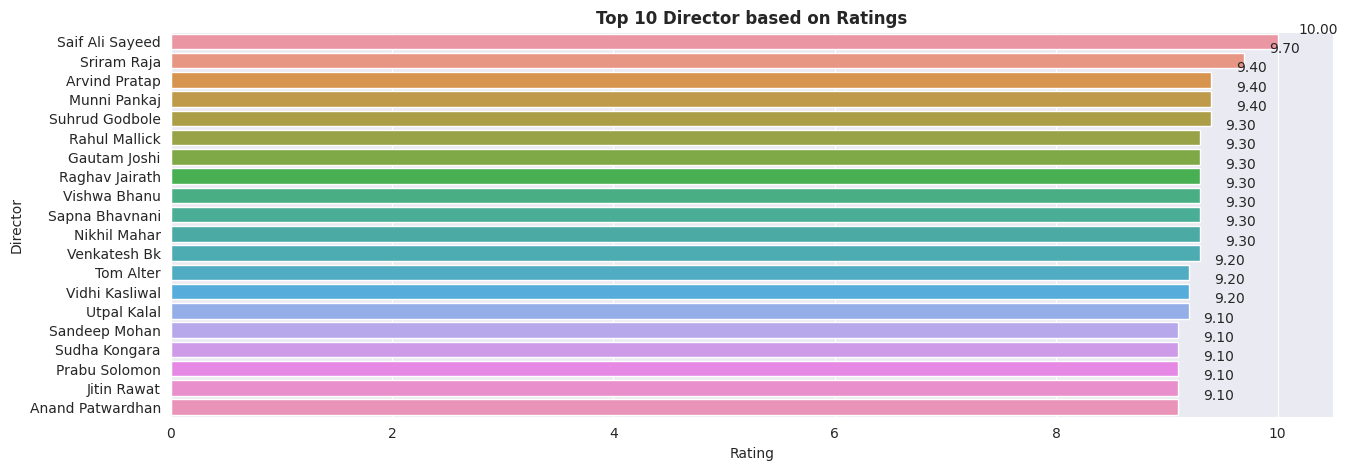

In [627]:
plt.figure(figsize=(15,5))

df = imdbData.set_index('Year')

top_directors = df[['Director','Rating']].sort_values(by = 'Rating', ascending=False).head(20)

moviePlots = sns.barplot(x='Rating', y='Director', data=top_directors)

for bar in moviePlots.patches:
  moviePlots.annotate(format(bar.get_width(),'.2f'),(bar.get_x() + bar.get_width()+0.3, bar.get_y()+0.5), ha='center',va='center',size=10, xytext=(5,10), textcoords='offset points')
  plt.xlabel("Rating",fontsize=10)
plt.ylabel("Director",fontsize=10)
plt.title("Top 10 Director based on Ratings",fontweight='bold')
plt.xticks(np.arange(0,11,2))
plt.yticks()
plt.show()

Saif Ali Sayeed, Sriram Raja, and Arvind Pratap's movies have top ratings.

# GENRE ANALYSIS

In this data, we have movies of single genre and also movies with genres seperated by a comma.

In [628]:
Genres = imdbData['Genre'].str.get_dummies(sep=', ')
GenreDF = pd.concat([imdbData, Genres], axis=1)
GenreDF = GenreDF.replace(0, np.nan)
GenreCount = GenreDF.drop(['Name','Year','Duration','Genre','Rating','Votes','Director','Actor 1'], axis=1).sum().sort_values(ascending=False)
GenreCount = pd.DataFrame(GenreCount)
GenreCount = GenreCount.rename(columns={0:'Count'})
GenreCount

,Count
Drama,3878.0
Action,1699.0
Romance,1383.0
Comedy,1352.0
Crime,878.0
Thriller,684.0
Family,428.0
Musical,416.0
Mystery,308.0
Adventure,284.0


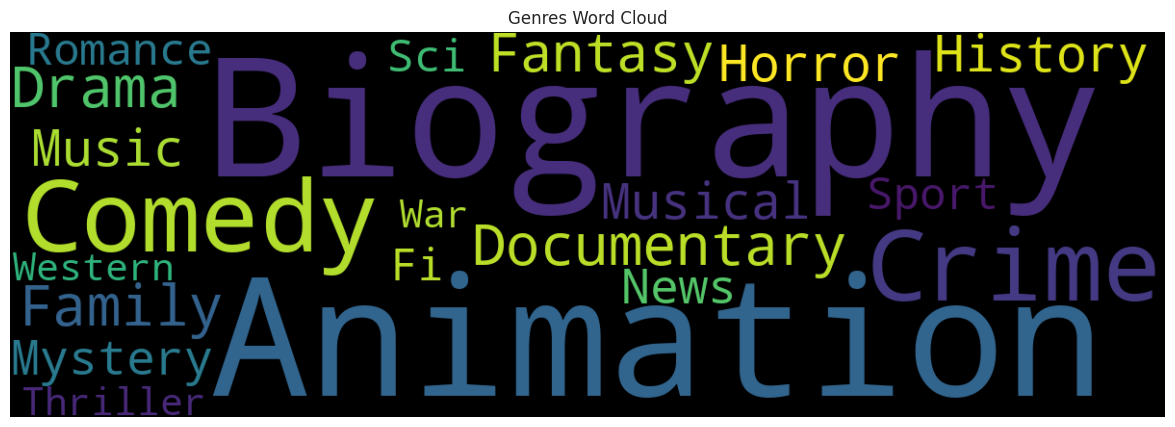

In [654]:
all_genres = ' '.join(GenreDF.columns[10:])
wordcloud = WordCloud(width=1200, height=400, background_color='black').generate(all_genres)

plt.figure(figsize=(15, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Genres Word Cloud')
plt.show()

Above word cloud represents the diverse Genres of the IMDb Movies dataset.

# FEATURE ENGINEERING

In [630]:
imdbData['Genre'].nunique()

393

In [631]:
imdbData['Director'].nunique()

2549

In [632]:
imdbData['Actor 1'].nunique()

2046

'Genre', 'Director' and  'Actor 1' columns have too diverse values. So, encoding them would create sparse values in the dataset.

In [633]:
#encoding 'Genre' column based on the count of each genre
genreCount = imdbData['Genre'].value_counts()
imdbData['GenreProcessed'] = imdbData['Genre'].map(genreCount)

In [634]:
#including a column that has genres based on rating
genreRating = imdbData.groupby('Genre')['Rating'].transform('mean')
imdbData['GenreRating'] = genreRating

In [635]:
#including a column that has directors based on rating
directorRating = imdbData.groupby('Director')['Rating'].transform('mean')
imdbData['DirectorRating'] = directorRating

In [636]:
#including a column that has actors based on rating
actorRating = imdbData.groupby('Actor 1')['Rating'].transform('mean')
imdbData['ActorRating'] = actorRating

In [637]:
imdbData.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,GenreProcessed,GenreRating,DirectorRating,ActorRating
1,#Gadhvi (He thought he was Gandhi),2019,109,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,901,6.419423,7.000000,6.850000
3,#Yaaram,2019,110,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,107,5.716822,4.400000,5.420000
5,...Aur Pyaar Ho Gaya,1997,147,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,45,6.242222,5.313333,4.788889
6,...Yahaan,2005,142,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,5,6.820000,7.383333,5.435000
8,?: A Question Mark,2012,82,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,9,5.477778,5.600000,5.600000


# DATA PREPROCESSING

In [638]:
mms = MinMaxScaler()
imdbData[['Rating','Votes','Year','Duration','GenreProcessed','GenreRating','DirectorRating','ActorRating']] = mms.fit_transform(imdbData[['Rating','Votes','Year','Duration','GenreProcessed','GenreRating','DirectorRating','ActorRating']])

In [639]:
imdbData.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,GenreProcessed,GenreRating,DirectorRating,ActorRating
1,#Gadhvi (He thought he was Gandhi),0.977778,0.293333,Drama,0.662921,0.000005,Gaurav Bakshi,Rasika Dugal,1.000000,0.597219,0.642857,0.633721
3,#Yaaram,0.977778,0.296667,"Comedy, Romance",0.370787,0.000051,Ovais Khan,Prateik,0.117778,0.502273,0.333333,0.467442
5,...Aur Pyaar Ho Gaya,0.733333,0.420000,"Comedy, Drama, Musical",0.404494,0.001390,Rahul Rawail,Bobby Deol,0.048889,0.573273,0.442063,0.394057
6,...Yahaan,0.822222,0.403333,"Drama, Romance, War",0.707865,0.001828,Shoojit Sircar,Jimmy Sheirgill,0.004444,0.651351,0.688492,0.469186
8,?: A Question Mark,0.900000,0.203333,"Horror, Mystery, Thriller",0.505618,0.000543,Allyson Patel,Yash Dave,0.008889,0.469970,0.476190,0.488372


# FEATURE SELECTION

In [640]:
x = imdbData.drop(columns=['Name','Director','Genre','Actor 1','Rating'])
x.head()

,Year,Duration,Votes,GenreProcessed,GenreRating,DirectorRating,ActorRating
1,0.977778,0.293333,0.000005,1.000000,0.597219,0.642857,0.633721
3,0.977778,0.296667,0.000051,0.117778,0.502273,0.333333,0.467442
5,0.733333,0.420000,0.001390,0.048889,0.573273,0.442063,0.394057
6,0.822222,0.403333,0.001828,0.004444,0.651351,0.688492,0.469186
8,0.900000,0.203333,0.000543,0.008889,0.469970,0.476190,0.488372


In [641]:
y = imdbData['Rating']
y.head()

1    0.662921
3    0.370787
5    0.404494
6    0.707865
8    0.505618
Name: Rating, dtype: float64

# TRAIN-TEST SPLIT

In [642]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [643]:
x_train.shape

(4680, 7)

In [644]:
x_test.shape

(1171, 7)

# MODEL EVALUATION

In [645]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
cv = cross_val_score(lr, x_train, y_train, cv=5)
print(cv)
print(cv.mean())

[0.72638414 0.72493084 0.74744489 0.67738065 0.73280707]
0.7217895180350402


In [646]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf')
cv = cross_val_score(svr, x_train, y_train, cv=5)
print(cv)
print(cv.mean())

[0.73929404 0.74171802 0.75180771 0.73534802 0.74406969]
0.7424474954217726


In [647]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth=5)
cv = cross_val_score(dtr, x_train, y_train, cv=5)
print(cv)
print(cv.mean())

[0.69230495 0.71002795 0.71913244 0.70152335 0.71298881]
0.7071954994394639


In [648]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth=5)
cv = cross_val_score(rfr, x_train, y_train, cv=5)
print(cv)
print(cv.mean())

[0.72039436 0.73542249 0.75112899 0.731867   0.74098874]
0.7359603181655656


'Support Vector Regressor' is the best fit with mean cross value score of 0.74.

# FITTING THE MODEL

In [649]:
svr.fit(x_train, y_train)

SVR()

# PREDICTIONS

In [650]:
predictedRatings = svr.predict(x_test)
print(predictedRatings)

[0.65019987 0.5764718  0.75949771 ... 0.45227817 0.55148588 0.56221439]


In [651]:
svr.predict([[0.977778,	0.293333,	0.000005,	1.000000,	0.597219,	0.642857,	0.633721]])

array([0.68647479])

# MODEL METRICS

In [652]:
from sklearn.metrics import r2_score, mean_squared_error

print(f'r2 score = {r2_score(y_test, predictedRatings)}')
print(f'mean squared error = {mean_squared_error(y_test, predictedRatings)}')

r2 score = 0.7103388717882905
mean squared error = 0.006803677496649623


Thank You
# HAPPY EXPLORATION!